# Import

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from google.colab import drive
drive.mount('/content/drive') 

BASE_PATH = '/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon'
DATA_PATH = BASE_PATH + '/data'

# Paths to input data
IMAGE_PATH = DATA_PATH + '/20210417144750'
IMAGE_GLOB_PATH = IMAGE_PATH + '/*.tif'
METADATA_PATH = DATA_PATH + '/output3.csv'

# Paths for output data
TENSORBOARD_PATH = BASE_PATH + '/logs'
MODEL_PATH = BASE_PATH + '/models'

# Max size of the training dataset to use (None to use all available data)
TRAINING_DATA_SIZE = 1000

# Size of the images being used
TARGET_SIZE = (200, 200)

# Batch size for training
BATCH_SIZE = 10

pprint(os.listdir(BASE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['data',
 'tensorflow',
 'Report draft.gdoc',
 'models',
 'logs',
 'modelsstd_scaler.bin',
 'std_scaler.bin',
 'datamapping.csv',
 'report template.gdoc']


# Loading model

In [ ]:
PATH_TO_H5 = MODEL_PATH + '/2021-04-17_16:39:32/checkpoints/model.09-0.0272.h5'
model = tf.keras.models.load_model(PATH_TO_H5)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

# Making predictions

{'F': array([1., 0., 0.]), 'HR': array([0., 1., 0.]), 'LR': array([0., 0., 1.])}


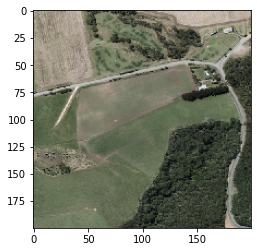

In [ ]:
from sklearn.externals.joblib import load
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import itertools
import timeit

sc = load('/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon/std_scaler.bin')
mapping = pd.read_csv('/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon/datamapping.csv')
mapping = { col: np.array(mapping[col]) for col in mapping.columns }
pprint(mapping)

TEST_IMAGE_PATH = '/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon trial/DATA/train/smol_set/9.tif'


# Load the image
def load_image(filepath, target_size=TARGET_SIZE):
  return img_to_array(load_img(filepath, target_size=target_size))

# Generate all permutation of input and predict with model
def test_permutations(filepath, datapoints=6):
  # Load, rescale, and reshape image input
  image = load_image(TEST_IMAGE_PATH)
  image /= 255

  # Generate all possible metadata inputs up to a certain precision
  weather = mapping.keys()
  brightness = np.linspace(0, 1, datapoints)
  speed = list(range(20, 121, 20))

  metadata = list(itertools.product(weather, brightness, speed))
  size = len(metadata)

  images = np.array([image] * size)
  inputs = np.array([np.concatenate([mapping[elem[0]], [elem[1]], [elem[2]]]) for elem in metadata])
  inputs = sc.transform(inputs)

  results = {
      'weather': list(map(lambda x: x[0], metadata)),
      'brightness': list(map(lambda x: x[1], metadata)),
      'speed': list(map(lambda x: x[2], metadata)),
      'severity': [elem[0] for elem in model.predict([images, inputs])]
  }

  return pd.DataFrame(results)


plt.imshow(load_image(TEST_IMAGE_PATH) / 255)
plt.show()
results = test_permutations(TEST_IMAGE_PATH)

In [ ]:
#results.weather[:,results.weather =='F']

#df = pd.DataFrame({"cats":["a","b"], "vals":[1,2]})
results.weather = results.weather.astype("category")
# results[results.weather.cat.categories == ['F']]
fine_weather_results = results.loc[results['weather'] == 'F']
heavy_rain_results = results.loc[results['weather'] == 'HR']
light_rain_results = results.loc[results['weather'] == 'LR']

In [ ]:
fine_weather_results

,weather,brightness,speed,severity
0,F,0.0,20,0.078157
1,F,0.0,40,0.081919
2,F,0.0,60,0.085680
3,F,0.0,80,0.089442
4,F,0.0,100,0.093204
5,F,0.0,120,0.096965
6,F,0.2,20,0.078688
7,F,0.2,40,0.082450
8,F,0.2,60,0.086212
9,F,0.2,80,0.089973


In [ ]:
light_rain_results

,weather,brightness,speed,severity
72,LR,0.0,20,0.129950
73,LR,0.0,40,0.133711
74,LR,0.0,60,0.137473
75,LR,0.0,80,0.141234
76,LR,0.0,100,0.144996
77,LR,0.0,120,0.148758
78,LR,0.2,20,0.130481
79,LR,0.2,40,0.134242
80,LR,0.2,60,0.138004
81,LR,0.2,80,0.141766


In [ ]:
heavy_rain_results

,weather,brightness,speed,severity
36,HR,0.0,20,0.093541
37,HR,0.0,40,0.097302
38,HR,0.0,60,0.101064
39,HR,0.0,80,0.104826
40,HR,0.0,100,0.108587
41,HR,0.0,120,0.112349
42,HR,0.2,20,0.094072
43,HR,0.2,40,0.097834
44,HR,0.2,60,0.101595
45,HR,0.2,80,0.105357


For the weather encoding,  
`F` is corresponed to fine weather.  
`LR` is corresponed to light rain.  
`HR` is corresponed to heavy rain.


You can tell the model picks up some of the weather pattern and speed limit pretend. In general, fine weather crashes has the lowest servirity. The crash serverity also increase as the speed limit increase.



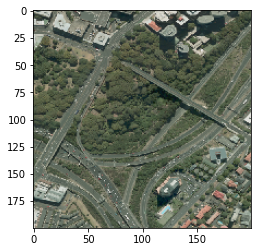

In [ ]:
TEST_IMAGE_PATH2 = '/content/drive/Shareddrives/Geospatial Hackathon 2021/hackathon trial/DATA/train/20210411015818/4783.tif'
plt.imshow(load_image(TEST_IMAGE_PATH2) / 255)
plt.show()
results = test_permutations(TEST_IMAGE_PATH2)



In [ ]:
fine_weather_results = results.loc[results['weather'] == 'F']
heavy_rain_results = results.loc[results['weather'] == 'HR']
light_rain_results = results.loc[results['weather'] == 'LR']

In [72]:
fine_weather_results

,weather,brightness,speed,severity
0,F,0.0,20,0.078157
1,F,0.0,40,0.081919
2,F,0.0,60,0.085680
3,F,0.0,80,0.089442
4,F,0.0,100,0.093204
5,F,0.0,120,0.096965
6,F,0.2,20,0.078688
7,F,0.2,40,0.082450
8,F,0.2,60,0.086212
9,F,0.2,80,0.089973


In [73]:
light_rain_results

,weather,brightness,speed,severity
72,LR,0.0,20,0.129950
73,LR,0.0,40,0.133711
74,LR,0.0,60,0.137473
75,LR,0.0,80,0.141234
76,LR,0.0,100,0.144996
77,LR,0.0,120,0.148758
78,LR,0.2,20,0.130481
79,LR,0.2,40,0.134242
80,LR,0.2,60,0.138004
81,LR,0.2,80,0.141766
